# [0] 모듈 로드

In [20]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10,10
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1, l2, l1_l2

from sklearn.metrics import classification_report

# [1] 데이터 로드

In [2]:
train = pd.read_json('./input/train.json')
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

In [3]:
test = pd.read_json('./input/test.json')
test.head()

,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874


In [4]:
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
len(train.band_1[0])

5625

In [6]:
np.array(train.band_1[0]).shape

(5625,)

# [2] 학습을 위해 numpy 형태로 변환

In [7]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [8]:
X_train[0]

array([[[-27.87836 , -27.154118, -27.51624 ],
        [-27.15416 , -29.537888, -28.346024],
        [-28.668615, -31.0306  , -29.849607],
        ...,
        [-25.573483, -29.095308, -27.334396],
        [-26.488674, -29.540878, -28.014776],
        [-30.507013, -27.511766, -29.00939 ]],

       [[-28.66853 , -31.030518, -29.849524],
        [-27.8784  , -33.529335, -30.703869],
        [-27.508776, -31.591175, -29.549976],
        ...,
        [-26.488632, -34.288055, -30.388344],
        [-28.671562, -28.267496, -28.469528],
        [-31.594166, -26.488716, -29.041441]],

       [[-28.66853 , -33.52929 , -31.09891 ],
        [-27.15416 , -37.05116 , -32.10266 ],
        [-25.865042, -31.591175, -28.728107],
        ...,
        [-27.157106, -31.594084, -29.375595],
        [-27.881393, -32.19339 , -30.037392],
        [-32.837124, -29.54092 , -31.189022]],

       ...,

       [[-29.092905, -27.87895 , -28.485928],
        [-28.669163, -27.878992, -28.274078],
        [-30.504612, -

In [9]:
test_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
test_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
test = np.concatenate([test_band_1[:, :, :, np.newaxis], test_band_2[:, :, :, np.newaxis],((test_band_1+test_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [10]:
test.shape

(8424, 75, 75, 3)

# [3] 빙산, 선적 시각화
- 참고 : https://www.kaggle.com/code/muonneutrino/exploration-transforming-images-in-python

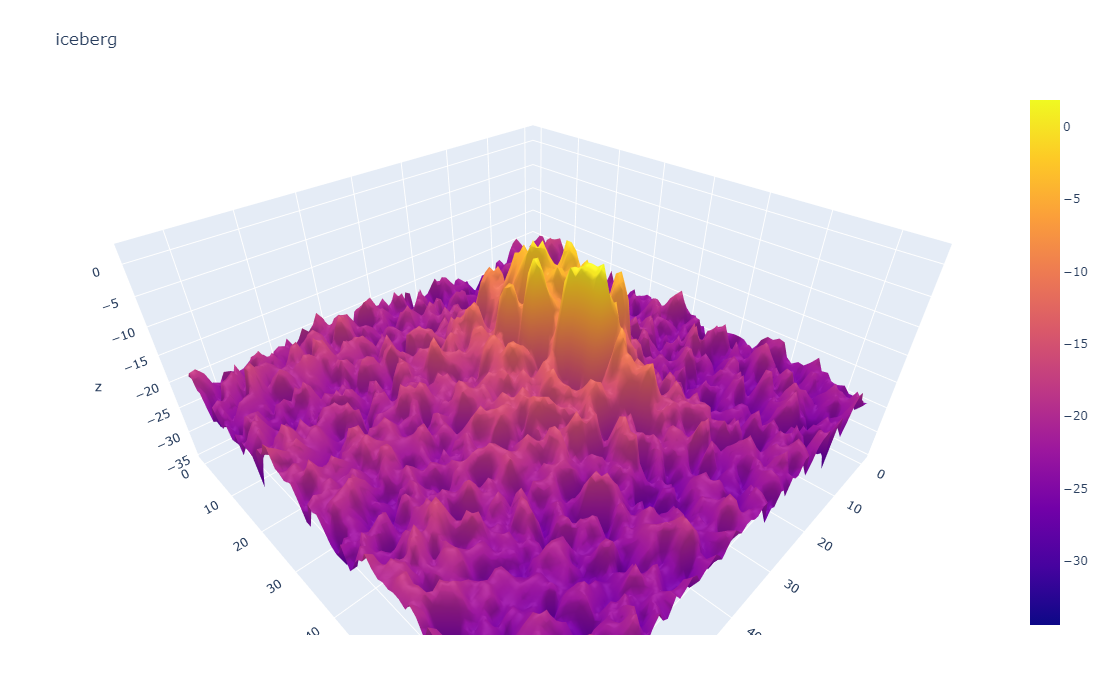

In [47]:
# iceberg를 가져온다.
def plotmy3d(c, name):
    data=[
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title = name,
        autosize= False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90            
        )        
    )
    fig= go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12,:,:], 'iceberg')

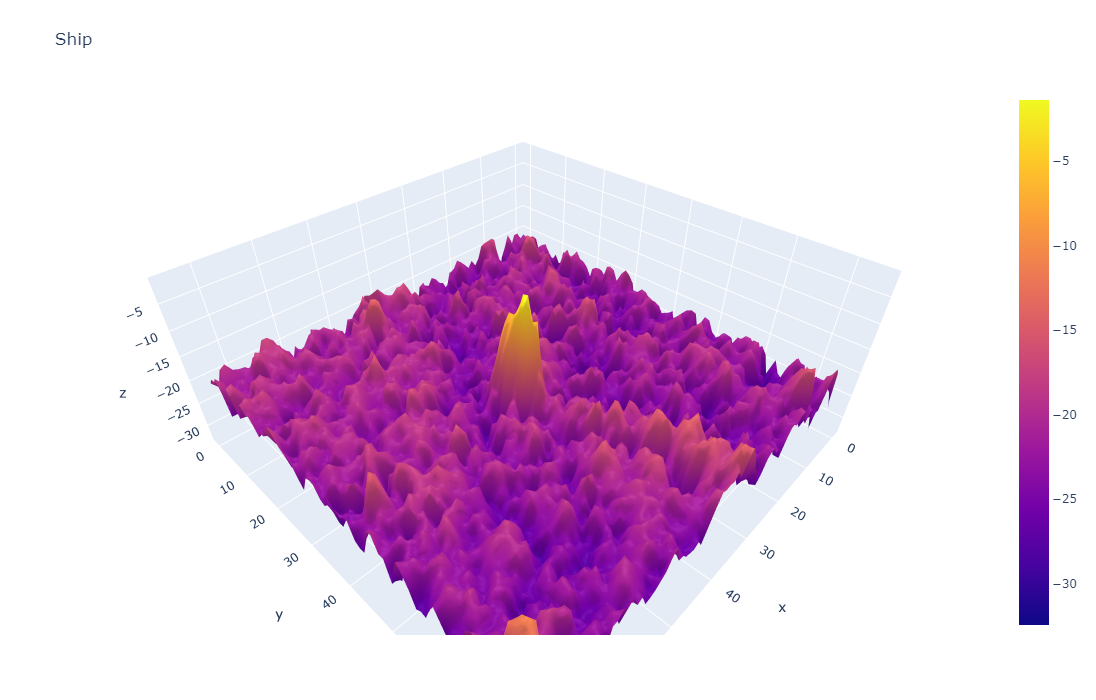

In [49]:
plotmy3d(X_band_1[14, :, :], 'Ship')

# [4] 모델 구축
- VGG16 전이 학습 사용

In [11]:
# VGG 16을 이용해보자
from tensorflow.keras.applications import vgg16

In [12]:
modelVgg16 = vgg16.VGG16(include_top = False, input_shape = (75,75,3))
modelVgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [13]:
for layer in modelVgg16.layers:
    layer.trainable = False

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, train.is_iceberg, random_state = 0)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1203, 75, 75, 3), (401, 75, 75, 3), (1203,), (401,))

In [17]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [22]:
model = Sequential()

model.add(modelVgg16)

model.add( BatchNormalization())

model.add(Flatten())

model.add(Dropout(0.2))
model.add(Dense(units = 64, activation = 'relu'))

model.add(Dropout(0.2))
model.add(Dense(units = 32, activation = 'relu'))

model.add(Dropout(0.2))
model.add(Dense(units = 36, activation = 'relu'))

model.add(Dense(units = 2, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 2, 2, 512)         2048      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                131136    
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [23]:
# 학습
model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
38/38 [==============================] - 21s 513ms/step - loss: 0.6021 - acc: 0.6525
Epoch 2/50
38/38 [==============================] - 20s 516ms/step - loss: 0.4316 - acc: 0.7797
Epoch 3/50
38/38 [==============================] - 19s 511ms/step - loss: 0.3779 - acc: 0.7955
Epoch 4/50
38/38 [==============================] - 24s 628ms/step - loss: 0.3306 - acc: 0.8462
Epoch 5/50
38/38 [==============================] - 25s 653ms/step - loss: 0.3082 - acc: 0.8603
Epoch 6/50
38/38 [==============================] - 23s 599ms/step - loss: 0.2859 - acc: 0.8687
Epoch 7/50
38/38 [==============================] - 22s 581ms/step - loss: 0.2636 - acc: 0.8703
Epoch 8/50
38/38 [==============================] - 23s 614ms/step - loss: 0.2559 - acc: 0.8803
Epoch 9/50
38/38 [==============================] - 22s 581ms/step - loss: 0.2428 - acc: 0.8886
Epoch 10/50
38/38 [==============================] - 22s 582ms/step - loss: 0.2286 - acc: 0.8894
Epoch 11/50
38/38 [====================

In [28]:
pred_train =  model.predict(X_train).argmax(axis = 1)

38/38 [==============================] - 18s 480ms/step


In [29]:
print(classification_report(y_train.argmax(axis = 1), pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       651
           1       1.00      1.00      1.00       552

    accuracy                           1.00      1203
   macro avg       1.00      1.00      1.00      1203
weighted avg       1.00      1.00      1.00      1203



In [30]:
pred_val =  model.predict(X_val).argmax(axis = 1)

13/13 [==============================] - 6s 483ms/step


In [31]:
print(classification_report(y_val.argmax(axis = 1), pred_val)) # 과적합 문제 발생

              precision    recall  f1-score   support

           0       0.79      0.72      0.76       200
           1       0.75      0.81      0.78       201

    accuracy                           0.77       401
   macro avg       0.77      0.77      0.77       401
weighted avg       0.77      0.77      0.77       401



# [6] submission 제작

In [32]:
sub = pd.read_csv('./input/sample_submission.csv')
sub.head()

,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5
2,b20200e4,0.5
3,e7f018bb,0.5
4,4371c8c3,0.5


In [33]:
pred_test = model.predict(test)

264/264 [==============================] - 162s 614ms/step


In [34]:
final_pred = pred_test.argmax(axis = 1)

In [35]:
sub['is_iceberg'] = final_pred

In [36]:
sub.to_csv('./input/submission.csv', index = False)

In [37]:
sub.head()

,id,is_iceberg
0,5941774d,1
1,4023181e,0
2,b20200e4,0
3,e7f018bb,1
4,4371c8c3,0
